# ChatGPT On Your Data(OYD)
### Data Ingestion

ChatGPT has taken the world by storm. Millions are using it. But while it’s great for general purpose knowledge, it only knows information about what it has been trained on, which is pre-2021 generally available internet data. It doesn’t know about your private data, it doesn’t know about recent sources of data.

#### High Level Walkthrough

At a high level, there are two components to setting up ChatGPT over your own data: (1) ingestion of the data, (2) chatbot over the data. Walking through the steps of each at a high level here:

##### Ingestion of data


Diagram of ingestion process
This can be broken in a few sub steps. All of these steps are highly modular and as part of this tutorial we will go over how to substitute steps out. The steps are:

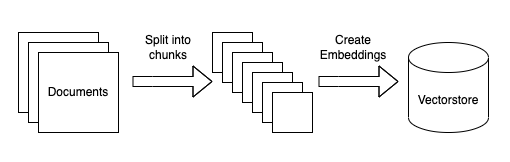

1. **Load data sources to text**: this involves loading your data from arbitrary sources to text in a form that it can be used downstream. This is one place where we hope the community will help out!

2. **Chunk text**: this involves chunking the loaded text into smaller chunks. This is necessary because language models generally have a limit to the amount of text they can deal with, so creating as small chunks of text as possible is necessary.

3. **Embed text**: this involves creating a numerical embedding for each chunk of text. This is necessary because we only want to select the most relevant chunks of text for a given question, and we will do this by finding the most similar chunks in the embedding space.

4. **Load embeddings to vectorstore**: this involves putting embeddings and documents into a vectorstore. Vecstorstores help us find the most similar chunks in the embedding space quickly and efficiently.

##### Ingestion of data

This section dives into more detail on the steps necessary to ingest data.

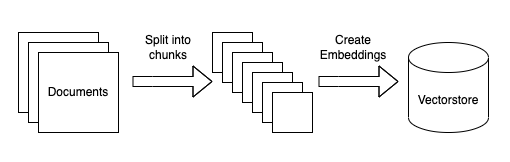

Diagram of ingestion process


##### Load Data

First, we need to load data into a standard format. Again, because this tutorial is focused on text data, the common format will be a LangChain Document object. This object is pretty simple and consists of (1) the text itself, (2) any metadata associated with that text (where it came from, etc).

Because there are so many potential places to load data from, this is one area we hope will be driven a lot by the community. At the very least, we hope to get a lot of example notebooks on how to load data from sources. Ideally, we will add the loading logic into the core library. See here for existing example notebooks, and see here for the underlying code. If you want to contribute, feel free to open a PR directly or open a GitHub issue with a snippet of your work.

The line below contains the line of code responsible for loading the relevant documents. If you want to change the logic for how the documents are loading, this is the line of code you should change.

```python
loader = UnstructuredFileLoader("state_of_the_union.txt")
raw_documents = loader.load()
```

In [ ]:
%pip install -qU langchain
%pip install -qU unstructured
%pip install -qU beautifulsoup4
#%pip install -qU faiss-cpu
%pip install -qU openai

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [ ]:
loader = UnstructuredFileLoader("state_of_the_union.txt")
raw_documents = loader.load()
len(raw_documents)

In [ ]:
raw_documents[0].page_content[:200]

##### Split Text

In addition to just loading the text, we also need to make sure to chunk it up into small pieces. This is necessary in order to make sure we only pass the smallest, most relevant pieces of text to the language model. In order to split up the text, we will need to initialize a text splitter and then call it on the raw documents.

The lines below are responsible for this. If you want to change how to the text is split, you should change these lines

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter()
documents = text_splitter.split_documents(raw_documents)
len(documents)

In [ ]:
[len(doc.page_content) for doc in documents]

In [ ]:
for doc in documents:
    print("---")
    print(f"{doc.page_content[:300]} <---> {doc.page_content[-300:]}")

##### Create embeddings and store in vectorstore

Next, now that we have small chunks of text we need to create embeddings for each piece of text and store them in a vectorstore. This is done so that we can use the embeddings to find only the most relevant pieces of text to send to the language model.

This is done with the following lines. Here we use OpenAI’s embeddings and a FAISS vectorstore. If we wanted to change either the embeddings used or the vectorstore used, this is where we would change them.

In [ ]:
import os
import pickle
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings

In [ ]:
# openai API key
os.environ["OPENAI_API_KEY"] = "KEY_GOES_HERE"

In [ ]:
embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(documents, embeddings)

Finally, we save the created vectorstore so we can use it later. That way, we only need to run this ingest script once.

In [ ]:
with open("vectorstore.pkl", "wb") as f:
	pickle.dump(vectorstore, f)

This is the entirety of the ingestion script! After you’ve modified this according to your preferences, you can then run `python ingest_data.py` to run the script. This should generate a `vectorstore.pkl` file.